In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import pandas_datareader as data

In [2]:
df= pd.read_csv('../dataset/ITC.NS.csv')

In [3]:
df.head()

,Datetime,Open,High,Low,Close,Adj Close,Volume
0,2023-01-24 09:30:00,339.299988,339.500000,337.750000,337.950012,337.950012,565145
1,2023-01-24 10:00:00,338.100006,340.200012,337.600006,340.049988,340.049988,857259
2,2023-01-24 10:30:00,340.000000,340.649994,339.500000,340.149994,340.149994,1343453
3,2023-01-24 11:00:00,340.200012,340.750000,339.750000,340.100006,340.100006,636284
4,2023-01-24 11:30:00,340.100006,340.250000,339.750000,339.850006,339.850006,367532


In [4]:
df.shape

(733, 7)

In [6]:
df= df.drop(['Datetime', 'Adj Close'], axis=1)

In [7]:
df.head()

,Open,High,Low,Close,Volume
0,339.299988,339.500000,337.750000,337.950012,565145
1,338.100006,340.200012,337.600006,340.049988,857259
2,340.000000,340.649994,339.500000,340.149994,1343453
3,340.200012,340.750000,339.750000,340.100006,636284
4,340.100006,340.250000,339.750000,339.850006,367532


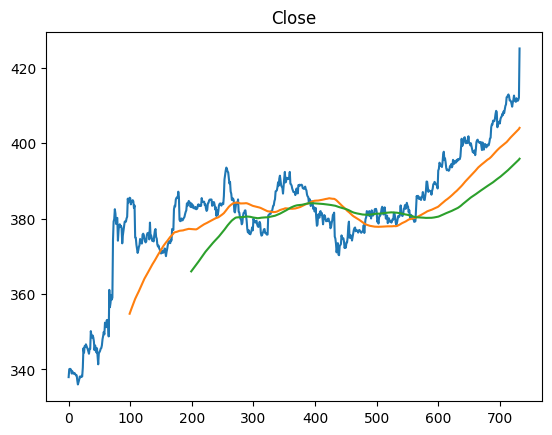

In [8]:
plt.plot(df['Close'])
plt.plot(df['Close'].rolling(100).mean())
plt.plot(df['Close'].rolling(200).mean())
plt.title('Close')
plt.show()

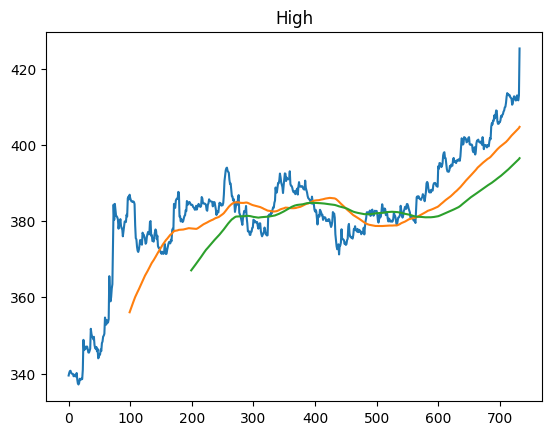

In [9]:
plt.plot(df['High'])
plt.plot(df['High'].rolling(100).mean())
plt.plot(df['High'].rolling(200).mean())
plt.title('High')
plt.show()

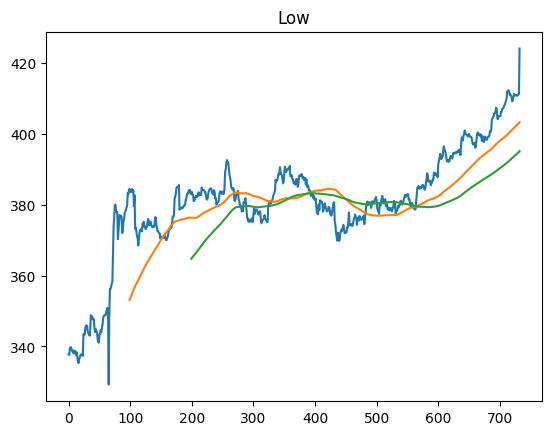

In [10]:
plt.plot(df['Low'])
plt.plot(df['Low'].rolling(100).mean())
plt.plot(df['Low'].rolling(200).mean())
plt.title('Low')
plt.show()

In [12]:
from sklearn.preprocessing import MinMaxScaler

scaler= MinMaxScaler(feature_range=(0,1))

In [17]:
scaledData= scaler.fit_transform(df['Close'].values.reshape(-1,1))

In [18]:
pd.DataFrame(scaledData)

,0
0,0.021873
1,0.045429
2,0.046551
3,0.045990
4,0.043186
...,...
728,0.845766
729,0.844083
730,0.846887
731,0.853618
